In [2]:
import torch
from torch.distributions import Bernoulli, Categorical, Beta, NegativeBinomial, Uniform, Normal
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import numpy as np


In [3]:
NR_AGENTS = 17000
NR_AGENTS_MEAN = 17000
NR_AGENTS_STD = 5000
PROBABILITY_CLIENT = 0.1
BUY_INTENTION_CONCENTRATION1 = 0.5
BUY_INTENTION_CONCENTRATION2 = 0.5 
NR_VISITS_TOTAL_COUNT = 20
NR_VISITS_PROBS = 0.8
THRESHOLD_BUY_DECISION = 0.5


In [4]:
optimal_weights = {
    'buy_intention_3': -0.47344485671163794, 
    'buy_intention_2': -0.7283462454140939, 
    'buy_intention_1': 1.4806023552101018, 
    'nr_visits_3': 2.900993116892826, 
    'nr_visits_2': -0.5829477745253755, 
    'nr_visits_1': -2.9480936975792282, 
    'client': 2.3896887289295865, 
    'discount_3': 0.04005516327927605, 
    'discount_2': -0.6292753303100818, 
    'discount_1': 0.2584994056915271, 
    'bias': -2.8080248377155983
    }


In [5]:
def generate_agents(probability_client=PROBABILITY_CLIENT, buy_intention_concentration1=BUY_INTENTION_CONCENTRATION1, \
                    buy_intention_concentration2=BUY_INTENTION_CONCENTRATION2,
                    nr_visits_total_count=NR_VISITS_TOTAL_COUNT, nr_visits_probs=NR_VISITS_PROBS, nr_samples=1000):
    
    buy_intention = Beta(buy_intention_concentration1, buy_intention_concentration2)
    client = Bernoulli(probability_client)
    nr_visits = NegativeBinomial(total_count=nr_visits_total_count, probs=nr_visits_probs)

    buy_intention_samples = buy_intention.sample((nr_samples,))
    client_samples = client.sample((nr_samples,))    
    nr_visits_samples = nr_visits.sample((nr_samples,))

    agents_tensor = torch.stack((buy_intention_samples, client_samples, nr_visits_samples), dim=1)
    return agents_tensor

def will_buy_polynomial_vectorized(agents, discount, weights, threshold=THRESHOLD_BUY_DECISION):

    weighted_sum = (
        weights['buy_intention_3'] * (agents[:,0] ** 3) +
        weights['buy_intention_2'] * (agents[:,0] ** 2) +
        weights['buy_intention_1'] * agents[:,0] +
        weights['nr_visits_3'] * ((agents[:,2] / 100) ** 3) +
        weights['nr_visits_2'] * ((agents[:,2] / 100) ** 2) +
        weights['nr_visits_1'] * (agents[:,2] / 100) +
        weights['client'] * agents[:,1] +
        weights['discount_3'] * (discount ** 3) +
        weights['discount_2'] * (discount ** 2) +
        weights['discount_1'] * discount +
        weights['bias'] 
    )
    
    buy_probabilities = torch.sigmoid(torch.tensor(weighted_sum))
    
    buy_decision = buy_probabilities > threshold
    return buy_decision.float()

def compute_buy_rate_per_day(weights, discount_sample, fixed_agents=True, nr_agents=NR_AGENTS, threshold=THRESHOLD_BUY_DECISION):
    if fixed_agents:
        agents = generate_agents(nr_samples=nr_agents)
        buy_decisions = will_buy_polynomial_vectorized(agents, discount_sample, weights, threshold=threshold)

    else:
        nr_agents_distribution = Normal(NR_AGENTS_MEAN, NR_AGENTS_STD)

        nr_agents = int(nr_agents_distribution.sample())
        agents = generate_agents(nr_samples=nr_agents)

        buy_decisions = will_buy_polynomial_vectorized(agents, discount_sample, weights, threshold=threshold)

    return buy_decisions.mean().item() * 100

## Multi armed bandits


In [48]:
class EpsilonGreedyMAB:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled
        self.values = np.zeros(n_arms)  # Estimated value (mean reward) for each arm

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

class RandomStrategy:
    def __init__(self, n_arms):
        self.n_arms = n_arms

    def select_arm(self):
        return np.random.randint(0, self.n_arms)

    def update(self, chosen_arm, reward):
        pass  # Random strategy does not learn, so no update is needed
    
class UCB:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm was pulled
        self.values = np.zeros(n_arms)  # Estimated value (mean reward) for each arm

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            new_value = self.values + math.sqrt((2*math.log(sum(self.counts)))/self.counts)
            return np.argmax(new_value)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

def simulate(algorithm='epsilon_greedy', discounts=[0.3, 0.5, 0.8],  n_days=10, epsilon=0.1):
    n_arms = 3
    # discounts = [0.3, 0.5, 0.8]  
    if algorithm == 'epsilon_greedy':
        mab = EpsilonGreedyMAB(n_arms, epsilon)
    elif algorithm == 'random':
        mab = RandomStrategy(n_arms)
    elif algorithm == 'UCB':
        mab = UCB(n_arms)

    rewards_per_day = np.zeros(n_days)

    for day in range(n_days):
        chosen_arm = mab.select_arm()
        discount = discounts[chosen_arm]

        # Simulate the buying process
        reward = compute_buy_rate_per_day(weights=optimal_weights, discount_sample=discount, \
                                          threshold=THRESHOLD_BUY_DECISION, fixed_agents=True)

        mab.update(chosen_arm, reward)

        rewards_per_day[day] = reward
        # print(f"Rewards day {day}: {reward} for discount {discount}")

    return rewards_per_day #, mab.values


In [46]:
def plot_average_rewards(n_days, epsilons, num_runs, discounts):

    average_rewards = np.zeros((len(epsilons), n_days))

    # Run simulations Epsilon Greedy 
    for i, epsilon in enumerate(epsilons):
        all_rewards = np.zeros((num_runs, n_days))
        
        for run in tqdm(range(num_runs)):
            rewards = simulate('epsilon_greedy', discounts, n_days, epsilon)
            all_rewards[run] = rewards
        
        average_rewards[i] = np.mean(all_rewards, axis=0)

    # Run simulations random
    all_rewards_random = np.zeros((num_runs, n_days))

    for run in tqdm(range(num_runs)):
        rewards = simulate('random', discounts, n_days)
        all_rewards_random[run] = rewards

    average_rewards_random = np.mean(all_rewards_random, axis=0)

    # Plotting
    fig = plt.figure(figsize=(14, 5))

    for i, epsilon in enumerate(epsilons):
        plt.plot(average_rewards[i], label=f'epsilon = {epsilon}')

    plt.plot(average_rewards_random, linestyle='dashed', label=f'random')

    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards Over Time for Different Epsilon Values')
    plt.legend()
    plt.show()

    plt.tight_layout()
    plt.show()

    return average_rewards, average_rewards_random

#### polynomial model with 1.07% buy rate 

In [45]:
n_days = 10
epsilons = [0.1, 0.01, 0.0]
num_runs = 100

average_rewards = np.zeros((len(epsilons), n_days))

# Run simulations Epsilon Greedy 
for i, epsilon in tqdm(enumerate(epsilons)):
    all_rewards = np.zeros((num_runs, n_days))
    
    for run in tqdm(range(num_runs)):
        rewards = simulate('epsilon_greedy', n_days, epsilon)
        all_rewards[run] = rewards
    
    average_rewards[i] = np.mean(all_rewards, axis=0)

# Run simulations random
all_rewards_random = np.zeros((num_runs, n_days))

for run in tqdm(range(num_runs)):
    rewards = simulate('random', n_days)
    all_rewards_random[run] = rewards

average_rewards_random = np.mean(all_rewards_random, axis=0)

# Plotting
fig = plt.figure(figsize=(14, 5))

for i, epsilon in enumerate(epsilons):
    plt.plot(average_rewards[i], label=f'epsilon = {epsilon}')

plt.plot(average_rewards_random, linestyle='dashed', label=f'random')

plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Rewards Over Time for Different Epsilon Values')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]
0it [00:00, ?it/s]


TypeError: expected a sequence of integers or a single integer, got '0.1'

In [21]:
average_rewards, average_rewards_random

(array([[1.16181271, 1.18229746, 1.14444156, 1.11489816, 1.12409383,
         1.20670161, 1.12781404, 1.07601774, 1.14651476, 1.15670174],
        [1.19380171, 1.16195248, 1.1763264 , 1.19907863, 1.20480666,
         1.25269929, 1.19043474, 1.18393357, 1.24856584, 1.16116501],
        [1.14515306, 1.15004679, 1.15196338, 1.21174215, 1.15252262,
         1.202122  , 1.21434977, 1.07527437, 1.16777056, 1.16032521]]),
 array([1.11502213, 1.08105451, 1.00018289, 1.12547413, 1.14087839,
        1.10000911, 1.08818869, 1.11514368, 1.11455695, 1.12092138]))

0it [00:00, ?it/s]C:\Users\aledragomir\AppData\Local\Temp\ipykernel_3636\3892493097.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  buy_probability = torch.sigmoid(torch.tensor(weighted_sum))
100%|██████████| 30/30 [04:09<00:00,  8.33s/it]
3it [12:33, 251.28s/it]
100%|██████████| 30/30 [03:56<00:00,  7.89s/it]


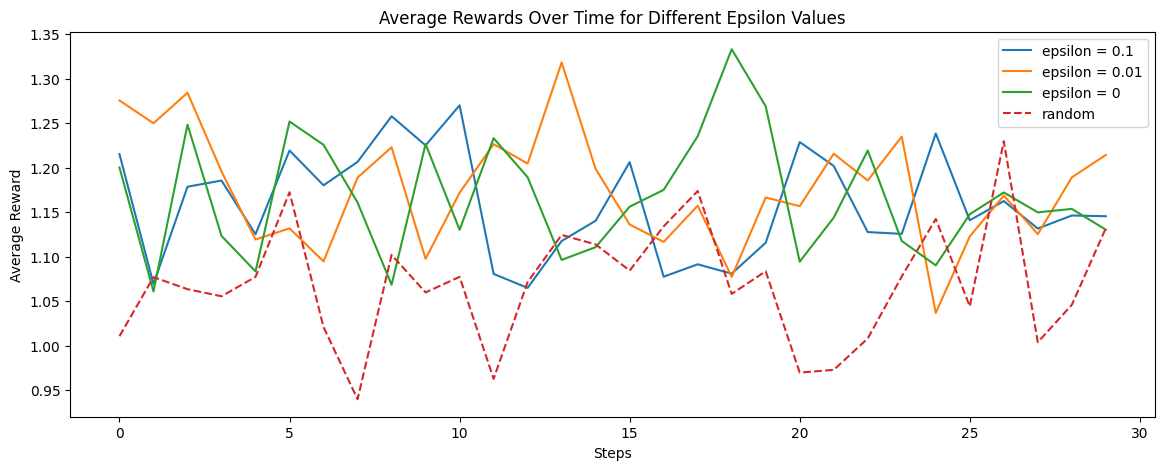

<Figure size 640x480 with 0 Axes>

In [25]:
average_rewards, average_rewards_random = plot_average_rewards(n_days=30, epsilons=[0.1, 0.01, 0], num_runs=30)

In [30]:
average_rewards, average_rewards_random

(array([[1.21522093, 1.06921342, 1.17851439, 1.18549452, 1.12511092,
         1.21926508, 1.18012543, 1.20647026, 1.25778269, 1.22500076,
         1.27008855, 1.08050801, 1.06479255, 1.11752654, 1.14028865,
         1.2061903 , 1.0773594 , 1.09130796, 1.08083136, 1.11558407,
         1.22878622, 1.20190906, 1.12755846, 1.12552306, 1.23841104,
         1.14080236, 1.16239634, 1.13151245, 1.1461773 , 1.14537059],
        [1.27552588, 1.24988634, 1.28422563, 1.1956925 , 1.11917494,
         1.13172612, 1.09456536, 1.18887627, 1.222841  , 1.09745902,
         1.17170704, 1.22637453, 1.20456033, 1.31825396, 1.19852084,
         1.13604668, 1.11647995, 1.15723799, 1.07715351, 1.1664567 ,
         1.15667525, 1.2156384 , 1.18553361, 1.23489965, 1.03657999,
         1.1226957 , 1.16852883, 1.12523432, 1.18903436, 1.21430766],
        [1.2001863 , 1.06073089, 1.24833598, 1.12322908, 1.08334647,
         1.25185155, 1.22564195, 1.16077377, 1.06834813, 1.22646041,
         1.13011475, 1.23311508,

### 360 days, 6 discounts, 30 runs, fixed number of agents, 17k

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\aledragomir\AppData\Local\Temp\ipykernel_3636\1780532963.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  buy_probabilities = torch.sigmoid(torch.tensor(weighted_sum))
100%|██████████| 30/30 [02:07<00:00,  4.26s/it]


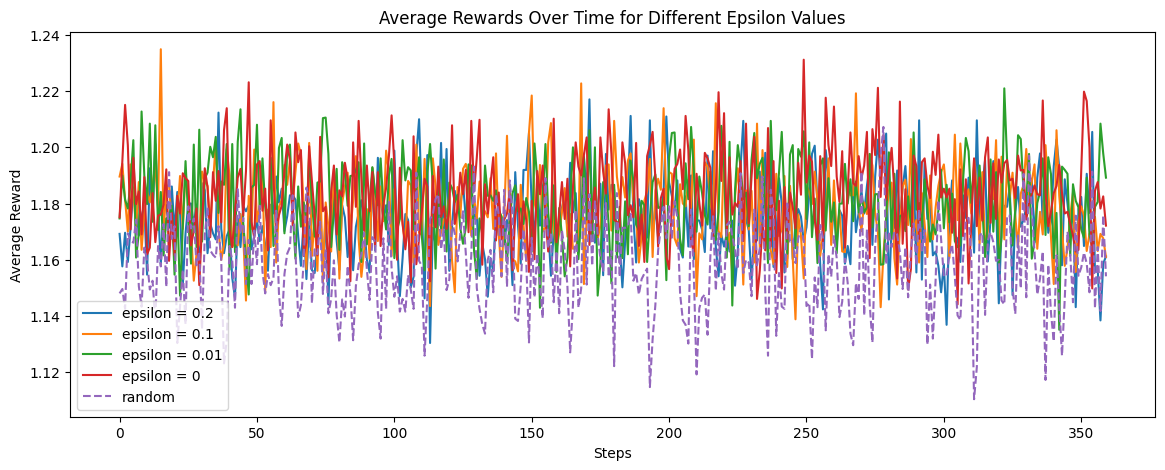

<Figure size 640x480 with 0 Axes>

In [47]:
average_rewards, average_rewards_random = plot_average_rewards(n_days=360, epsilons=[0.2, 0.1, 0.01, 0], num_runs=30,\
                                                                discounts=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [32]:
average_rewards, average_rewards_random

(array([[1.18741367, 1.1862529 , 1.16054612, 1.17619626, 1.21533732,
         1.11257381, 1.12371169, 1.1813996 , 1.15746604, 1.16242345,
         1.1908092 , 1.06629586, 1.21042351, 1.23325129, 1.3057546 ,
         1.13783898, 1.04057248, 1.2287925 , 1.15777867, 1.21250941,
         1.23765635, 1.13572543, 1.19928468, 1.19766724, 1.26609774,
         1.10780743, 1.14387305, 1.08600282, 1.21221205, 1.15272646],
        [1.2047195 , 1.1557749 , 1.07313166, 1.16291013, 1.14208092,
         1.11893361, 1.15922839, 1.24711628, 1.17180866, 1.22323055,
         1.21860999, 1.17239532, 1.13468488, 1.2134002 , 1.22279662,
         1.27667585, 1.07369551, 1.20780523, 1.23407446, 1.24482975,
         1.15565493, 1.29900262, 1.1389983 , 1.14930348, 1.07276355,
         1.2483093 , 1.05743699, 1.2250611 , 1.18300517, 1.21640257],
        [1.1628409 , 1.17997711, 1.15770912, 1.18063084, 1.16569049,
         1.11780142, 1.15367538, 1.17157225, 1.16928568, 1.17888125,
         1.17642997, 1.12915549,

#### old polynomial model

0it [00:00, ?it/s]C:\Users\aledragomir\AppData\Local\Temp\ipykernel_3636\3976252741.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  buy_probability = torch.sigmoid(torch.tensor(weighted_sum))
100%|██████████| 100/100 [01:46<00:00,  1.06s/it]
3it [05:08, 102.74s/it]
100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


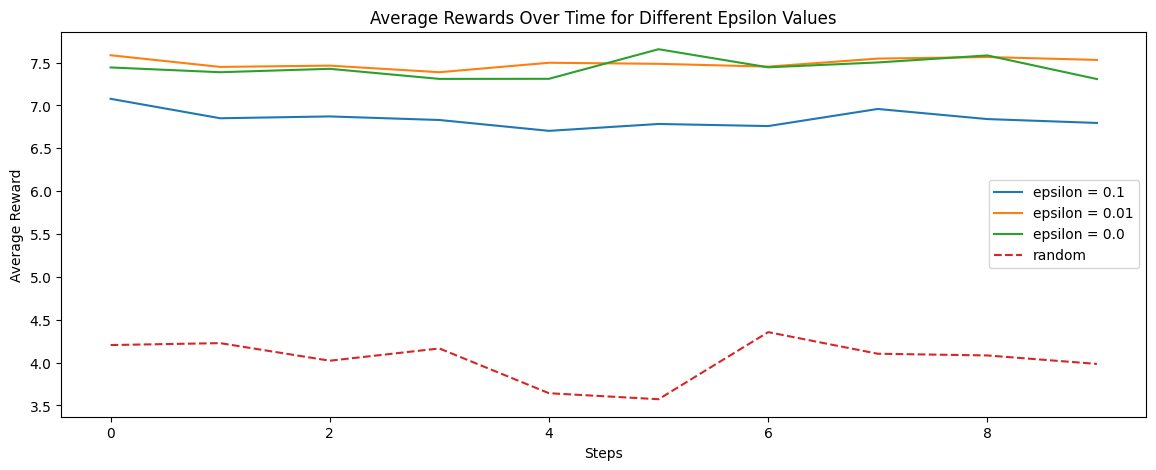

<Figure size 640x480 with 0 Axes>

In [ ]:
# Parameters
n_days = 10
epsilons = [0.1, 0.01, 0.0]
num_runs = 100

# Initialize storage for rewards and optimal actions
average_rewards = np.zeros((len(epsilons), n_days))

# Run simulations Epsilon Greedy 
for i, epsilon in tqdm(enumerate(epsilons)):
    all_rewards = np.zeros((num_runs, n_days))
    
    for run in tqdm(range(num_runs)):
        rewards = simulate('epsilon_greedy', n_days, epsilon)
        all_rewards[run] = rewards
    
    # Average the results over all runs
    average_rewards[i] = np.mean(all_rewards, axis=0)

# Run simulations random
all_rewards_random = np.zeros((num_runs, n_days))

for run in tqdm(range(num_runs)):
    rewards = simulate('random', n_days)
    all_rewards_random[run] = rewards

# Average the results over all runs
average_rewards_random = np.mean(all_rewards_random, axis=0)

# Plotting
fig = plt.figure(figsize=(14, 5))

# Plot Average Reward
for i, epsilon in enumerate(epsilons):
    plt.plot(average_rewards[i], label=f'epsilon = {epsilon}')

plt.plot(average_rewards_random, linestyle='dashed', label=f'random')

plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Rewards Over Time for Different Epsilon Values')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

0it [00:00, ?it/s]C:\Users\aledragomir\AppData\Local\Temp\ipykernel_22960\3976252741.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  buy_probability = torch.sigmoid(torch.tensor(weighted_sum))
100%|██████████| 100/100 [05:00<00:00,  3.00s/it]
3it [14:40, 293.51s/it]


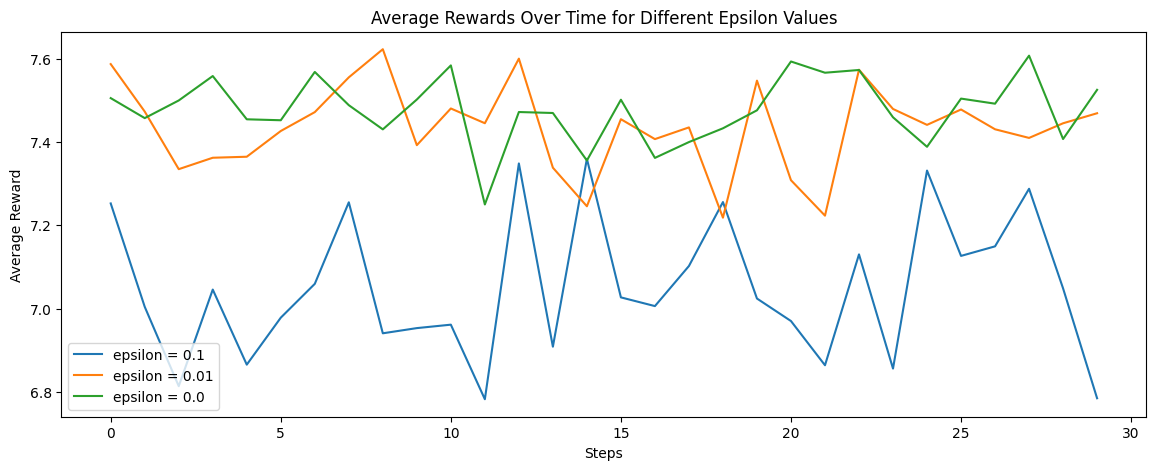

<Figure size 640x480 with 0 Axes>

In [ ]:
# Parameters
n_days = 30
epsilons = [0.1, 0.01, 0.0]
num_runs = 100

# Initialize storage for rewards and optimal actions
average_rewards = np.zeros((len(epsilons), n_days))

# Run simulations
for i, epsilon in tqdm(enumerate(epsilons)):
    all_rewards = np.zeros((num_runs, n_days))
    
    for run in tqdm(range(num_runs)):
        rewards, _ = simulate(compute_buy_rate_per_day, n_days, epsilon)
        all_rewards[run] = rewards
    
    # Average the results over all runs
    average_rewards[i] = np.mean(all_rewards, axis=0)

# Plotting
fig = plt.figure(figsize=(14, 5))

# Plot Average Reward
for i, epsilon in enumerate(epsilons):
    plt.plot(average_rewards[i], label=f'epsilon = {epsilon}')

plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Rewards Over Time for Different Epsilon Values')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

## MABP example Sutton

In [20]:
import math 

class EpsilonGreedyMAB:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.N = np.zeros(n_arms)  # Number of times each arm was pulled
        self.Q = np.zeros(n_arms)  # Estimated value (mean reward) for each arm
        self.q_star = np.random.normal(size=n_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.Q)

    def update(self, chosen_arm, reward):
        self.N[chosen_arm] += 1
        n = self.N[chosen_arm]
        value = self.Q[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.Q[chosen_arm] = new_value

class RandomStrategy:
    def __init__(self, n_arms):
        self.n_arms = n_arms

    def select_arm(self):
        return np.random.randint(0, self.n_arms)

    def update(self, chosen_arm, reward):
        pass  # Random strategy does not learn, so no update is needed

class UCB:
    def __init__(self, n_arms, confidence):
        self.confidence = confidence
        self.n_arms = n_arms
        self.N = np.zeros(n_arms)  # Number of times each arm was pulled
        self.Q = np.zeros(n_arms)  # Estimated value (mean reward) for each arm
        self.q_star = np.random.normal(size=n_arms)

    def select_arm(self):
        n_arms = len(self.N)
        for arm in range(n_arms):
            if self.N[arm] == 0:
                return arm
    
        ucb_values = [0.0 for _ in range(n_arms)]
        total_counts = sum(self.N)
        
        for arm in range(n_arms):
            bonus = math.sqrt((math.log(total_counts)) / float(self.N[arm]))
            ucb_values[arm] = self.Q[arm] + self.confidence * bonus
        return ucb_values.index(max(ucb_values))
    

    def update(self, chosen_arm, reward):
        self.N[chosen_arm] += 1
        n = self.N[chosen_arm]
        value = self.Q[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.Q[chosen_arm] = new_value
        
def simulate(algorithm='epsilon-greedy', n_days=10, epsilon=0.1):
    n_arms = 10
    if algorithm == 'epsilon-greedy':
        mab = EpsilonGreedyMAB(n_arms, epsilon)
    elif algorithm == 'ucb':
        mab = UCB(n_arms, 2)

    rewards_per_day = np.zeros(n_days)

    for day in range(n_days):
        chosen_arm = mab.select_arm()
        # normal_distribution = Normal(0, 1)
        # reward = normal_distribution.sample()
        reward = np.random.normal(mab.q_star[chosen_arm], 1)
        mab.update(chosen_arm, reward)

        rewards_per_day[day] = reward
        # print(f"Rewards day {day}: {reward} for discount {discount}")

    return rewards_per_day, mab.Q



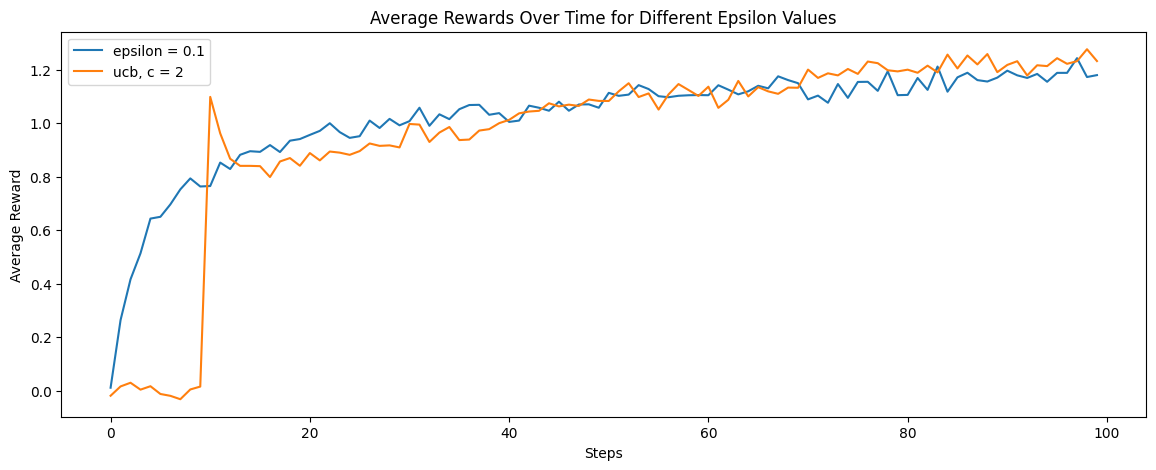

<Figure size 640x480 with 0 Axes>

In [22]:
# Parameters
n_days = 100
epsilons = [0.1]
num_runs = 2000

# Initialize storage for rewards and optimal actions
average_rewards_eps = np.zeros((len(epsilons), n_days))

# Run simulations
for i, epsilon in enumerate(epsilons):
    all_rewards = np.zeros((num_runs, n_days))
    
    for run in range(num_runs):
        rewards, _ = simulate('epsilon-greedy', n_days, epsilon)
        all_rewards[run] = rewards
    
    # Average the results over all runs
    average_rewards_eps[i] = np.mean(all_rewards, axis=0)

all_rewards = np.zeros((num_runs, n_days))
    
for run in range(num_runs):
    rewards, _ = simulate("ucb", n_days)
    all_rewards[run] = rewards

# Average the results over all runs
average_rewards_ucb = np.mean(all_rewards, axis=0)

# Plotting
fig = plt.figure(figsize=(14, 5))

# Plot Average Reward
for i, epsilon in enumerate(epsilons):
    plt.plot(average_rewards_eps[i], label=f'epsilon = {epsilon}')

plt.plot(average_rewards_ucb, label=f'ucb, c = 2')

plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Rewards Over Time for Different Epsilon Values')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

In [ ]:
def init_bandit(n):
    q_star = np.random.normal(size=n)
    Q = np.zeros(n)
    N = np.zeros(n)
    return q_star, Q, N


In [ ]:
q_star, _, _ = init_bandit(8)

x = np.linspace(q_star[0]-4, q_star[0]+4, 100)
y = 1/(np.sqrt(2*np.pi)) * np.exp(-0.5*(x-q_star[0])**2)
plt.plot(x,y)
plt.show()

In [ ]:
def select_action(Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(Q))
    else:
        return np.argmax(Q)
    
def run_bandit(n, num_steps, epsilon):
    q_star, Q, N = init_bandit(n)
    rewards = np.zeros(num_steps)
    optimal = np.zeros(num_steps)

    for i in range(num_steps):
        action = select_action(Q, epsilon)
        reward = np.random.normal(q_star[action], 1)
        rewards[i] = reward
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]

        if action == np.argmax(q_star):
            optimal[i] = 1
    
    return rewards, optimal

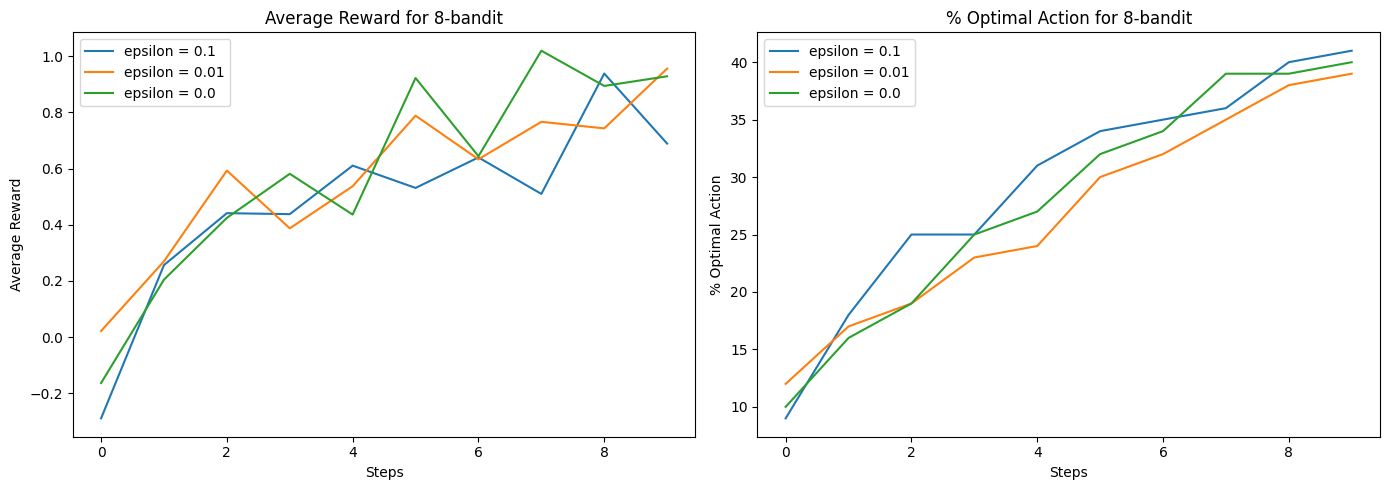

In [ ]:
# Parameters
n_bandits = 8
num_steps = 10
epsilons = [0.1, 0.01, 0.0]
num_runs = 100

# Initialize storage for rewards and optimal actions
average_rewards = np.zeros((len(epsilons), num_steps))
optimal_actions = np.zeros((len(epsilons), num_steps))

# Run simulations
for i, epsilon in enumerate(epsilons):
    all_rewards = np.zeros((num_runs, num_steps))
    all_optimal = np.zeros((num_runs, num_steps))
    
    for run in range(num_runs):
        rewards, optimal = run_bandit(n_bandits, num_steps, epsilon)
        all_rewards[run] = rewards
        all_optimal[run] = optimal
    
    # Average the results over all runs
    average_rewards[i] = np.mean(all_rewards, axis=0)
    optimal_actions[i] = np.mean(all_optimal, axis=0) * 100  # Convert to percentage

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Average Reward
for i, epsilon in enumerate(epsilons):
    axes[0].plot(average_rewards[i], label=f'epsilon = {epsilon}')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Average Reward')
axes[0].set_title('Average Reward for 8-bandit')
axes[0].legend()

# Plot % Optimal Action
for i, epsilon in enumerate(epsilons):
    axes[1].plot(optimal_actions[i], label=f'epsilon = {epsilon}')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('% Optimal Action')
axes[1].set_title('% Optimal Action for 8-bandit')
axes[1].legend()

plt.tight_layout()
plt.show()

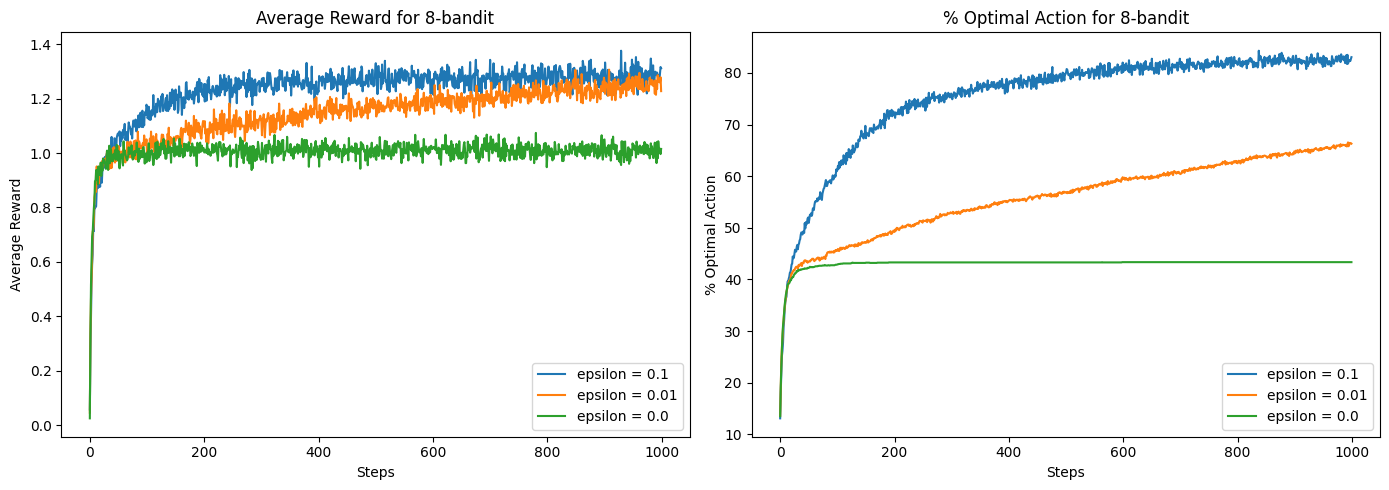

In [ ]:
# Parameters
n_bandits = 8
num_steps = 1000
epsilons = [0.1, 0.01, 0.0]
num_runs = 2000

# Initialize storage for rewards and optimal actions
average_rewards = np.zeros((len(epsilons), num_steps))
optimal_actions = np.zeros((len(epsilons), num_steps))

# Run simulations
for i, epsilon in enumerate(epsilons):
    all_rewards = np.zeros((num_runs, num_steps))
    all_optimal = np.zeros((num_runs, num_steps))
    
    for run in range(num_runs):
        rewards, optimal = run_bandit(n_bandits, num_steps, epsilon)
        all_rewards[run] = rewards
        all_optimal[run] = optimal
    
    # Average the results over all runs
    average_rewards[i] = np.mean(all_rewards, axis=0)
    optimal_actions[i] = np.mean(all_optimal, axis=0) * 100  # Convert to percentage

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Average Reward
for i, epsilon in enumerate(epsilons):
    axes[0].plot(average_rewards[i], label=f'epsilon = {epsilon}')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Average Reward')
axes[0].set_title('Average Reward for 8-bandit')
axes[0].legend()

# Plot % Optimal Action
for i, epsilon in enumerate(epsilons):
    axes[1].plot(optimal_actions[i], label=f'epsilon = {epsilon}')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('% Optimal Action')
axes[1].set_title('% Optimal Action for 8-bandit')
axes[1].legend()

plt.tight_layout()
plt.show()
